# Import cleaned EIA/EPA data and calculate final Emissions Index/Generation by Fuel data

This notebook makes use of data created in the notebooks (nested levels indicate a chain of calculations):
- EIA Bulk Download - extract facility generation
    - Emission factors
- EIA bulk download - non-facility (distributed PV & state-level)
    - Emission factors
- Group EPA emissions data by month and quarter
    - Load EPA Emissions Data
    


In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import os
import numpy as np
# init_notebook_mode(connected=True)
import datetime as dt

## Contents
- [Import data](#Import-cleaned-data)
    - [EIA facility data](#Facility-generation-and-CO2-emissions)
    - [Total EIA gen & emissions](#Total-EIA-generation-and-CO2-emissions)
    - [EPA emissions data](#Load-EPA-data)
- [Check EIA facility against EIA total](#Check-EIA-facility-data-against-EIA-total-data-(gen-&-CO2))
- [Adjust EPA facility emissions](#Correct-EPA-facility-emissions)
- [Difference between EIA facility and total](#Emissions-and-gen-not-captured-by-facilities)
- [Combine all data (monthly)](#Add-EPA-emissions-back-to-the-EIA-df,-use-EIA-emissions-where-EPA-don't-exist,-add-extra-EIA-emissions-for-state-level-data)
- [Create plots](#Plots)
    - [Monthly Index](#Monthly-Index)
    - [Quarterly Index](#Quarterly-Index)
    - [Annual Index](#Annual-Index)
    

## Import cleaned data
1. Facility generation and CO2 emissions
2. Total generation and CO2 emissions by fuel
3. EPA CO2 emissions

Create some helper functions to add datetime and quarter columns

In [2]:
def add_datetime(df, year='year', month='month'):
    df['datetime'] = pd.to_datetime(df[year].astype(str) + '-' + df[month].astype(str),
                                    format='%Y-%m')

def add_quarter(df, year='year', month='month'):
    add_datetime(df, year, month)
    df['quarter'] = df['datetime'].dt.quarter

### Facility generation and CO2 emissions

In [3]:
path = os.path.join('Facility gen fuels and CO2.csv')
eia_facility = pd.read_csv(path, parse_dates=['datetime'], low_memory=False)

### EIA Facility level emissions (consolidate fuels/prime movers)
Because EIA tracks all fuel consumption at facilities that might produce both electricity and useful thermal output (CHP), CO<sub>2</sub> emissions can be from one 4 categories:
1. Total fuel consumption for all uses (fossil & non-fossil, electricity & thermal output)
2. Fossil fuel consumption for all uses (electricity only or CHP)
3. Total fuel consumption for electricity only
4. Fossil fuel consumption for electricity only

We are interested in Category 4. EPA reports total emissions (Category 1), which need to be adjusted. To do this, we calculate a ratio

$$CO_2 \ Ratio = \frac{Category \ 4}{Category \ 1}$$

Will will apply the CO<sub>2</sub> ratio factors to EPA data [later in this notebook](#Correct-EPA-facility-emissions).

In [4]:
cols = ['all fuel fossil CO2 (kg)','elec fuel fossil CO2 (kg)',
        'all fuel total CO2 (kg)','elec fuel total CO2 (kg)', 'generation (MWh)']
eia_facility_grouped = eia_facility.groupby(['year', 'month', 'plant id'])[cols].sum()
eia_facility_grouped.reset_index(inplace=True)
eia_facility_grouped['CO2 ratio'] = eia_facility_grouped['elec fuel fossil CO2 (kg)'] / eia_facility_grouped['all fuel total CO2 (kg)']
eia_facility_grouped['CO2 ratio'].fillna(0, inplace=True)
eia_facility_grouped.head()

,year,month,plant id,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg),generation (MWh),CO2 ratio
0,2001,1,2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,18918.0,0.0
1,2001,1,3,8.905017e+08,8.905017e+08,8.905017e+08,8.905017e+08,1158644.0,1.0
2,2001,1,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,51843.0,0.0
3,2001,1,7,5.501578e+07,5.501578e+07,5.501578e+07,5.501578e+07,46411.0,1.0
4,2001,1,8,6.457039e+08,6.457039e+08,6.457039e+08,6.457039e+08,707902.0,1.0


### Total EIA generation and CO2 emissions

In [5]:
path = os.path.join('EIA country-wide gen fuel CO2.csv')
eia_total = pd.read_csv(path, parse_dates=['datetime'], low_memory=False)

In [6]:
eia_total['type'].unique()

array(['AOR', 'DPV', 'GEO', 'HPS', 'HYC', 'PC', 'COW', 'OOG', 'OTH', 'NUC',
       'NG', 'WAS', 'STH', 'SPV', 'PEL', 'TSN', 'SUN', 'WWW', 'WND'], dtype=object)

#### Consolidate total EIA to monthly gen and emissions
Only keep non-overlapping fuel categories so that my totals are correct (e.g. don't keep utility-scale photovoltaic, because it's already counted in utility-scale solar [SUN]).

In [7]:
keep_types = [u'WWW', u'WND', u'WAS', u'SUN', 'DPV', u'NUC', u'NG',
       u'PEL', u'PC', u'OTH', u'COW', u'OOG', u'HPS', u'HYC', u'GEO']
keep_cols = ['generation (MWh)', 'total fuel (mmbtu)', 'elec fuel (mmbtu)',
             'all fuel CO2 (kg)', 'elec fuel CO2 (kg)']
eia_total_monthly = eia_total.loc[(eia_total['type'].isin(keep_types))].groupby(['type', 'year', 'month'])[keep_cols].sum()

In [8]:
eia_total_monthly.head()

generation (MWh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
type year month                                                            
COW  2001 1           177287111.0        1.865793e+09       1.823462e+09   
          2           149735484.0        1.583640e+09       1.547591e+09   
          3           155269011.0        1.644568e+09       1.605916e+09   
          4           140670654.0        1.485098e+09       1.449735e+09   
          5           151592914.0        1.609281e+09       1.574618e+09   

                 all fuel CO2 (kg)  elec fuel CO2 (kg)  
type year month                                         
COW  2001 1           1.777168e+11        1.736848e+11  
          2           1.508417e+11        1.474080e+11  
          3           1.566451e+11        1.529635e+11  
          4           1.414556e+11        1.380873e+11  
          5           1.532840e+11        1.499824e+11

Pretty sure that I don't need to keep `eia_total_annual`

In [9]:
keep_types = [u'WWW', u'WND', u'WAS', u'TSN', u'NUC', u'NG',
       u'PEL', u'PC', u'OTH', u'COW', u'OOG', u'HPS', u'HYC', u'GEO']

eia_total_annual = eia_total_monthly.reset_index().groupby('year').sum()
eia_total_annual['index (g/kWh)'] = eia_total_annual['elec fuel CO2 (kg)'] / eia_total_annual['generation (MWh)']

### Load EPA data
Check to see if there are multiple rows per facility for a single month

In [10]:
path = os.path.join('Monthly EPA emissions.csv')
epa = pd.read_csv(path)

In [11]:
add_quarter(epa, year='YEAR', month='MONTH')
epa.head()

,CO2_MASS (kg),GLOAD (MW),HEAT_INPUT (mmBtu),MONTH,OP_TIME,ORISPL_CODE,SLOAD (1000lb/hr),YEAR,datetime,quarter
0,9.625411e+08,1167596.0,1.113000e+07,1,4348.25,3,NaN,2001,2001-01-01,1
1,8.208495e+08,880517.0,8.951275e+06,2,3391.00,3,NaN,2001,2001-02-01,1
2,6.402928e+08,735523.0,7.175850e+06,3,3846.50,3,NaN,2001,2001-03-01,1
3,7.417879e+08,898023.0,8.519262e+06,4,4292.75,3,NaN,2001,2001-04-01,2
4,9.767243e+08,1230441.0,1.138663e+07,5,5029.75,3,NaN,2001,2001-05-01,2


Fill nan's with 0

In [12]:
epa.loc[:,'CO2_MASS (kg)'].fillna(0, inplace=True)

## Correct EPA facility emissions
Use the EIA facility adjustment factors to correct for CHP and biomass emissions

**Use an inner merge rather than left**  
Justification: a left merge will retain CO2 emissions from facilities that aren't included in 923. But the generation and emissions for those facilities *are* included in the state-level estimates. 

In [13]:
eia_keep = ['month', 'year', 'all fuel total CO2 (kg)', 'CO2 ratio', 'plant id']

epa_adj = epa.merge(eia_facility_grouped[eia_keep], left_on=['ORISPL_CODE', 'YEAR', 'MONTH'],
                right_on=['plant id', 'year', 'month'], how='inner') # how='left

epa_adj.drop(['month', 'year', 'plant id'], axis=1, inplace=True)
epa_adj['epa index'] = epa_adj.loc[:,'CO2_MASS (kg)'] / epa_adj.loc[:,'GLOAD (MW)']
epa_adj.head()

,CO2_MASS (kg),GLOAD (MW),HEAT_INPUT (mmBtu),MONTH,OP_TIME,ORISPL_CODE,SLOAD (1000lb/hr),YEAR,datetime,quarter,all fuel total CO2 (kg),CO2 ratio,epa index
0,9.625411e+08,1167596.0,1.113000e+07,1,4348.25,3,NaN,2001,2001-01-01,1,8.905017e+08,1.0,824.378547
1,8.208495e+08,880517.0,8.951275e+06,2,3391.00,3,NaN,2001,2001-02-01,1,7.570004e+08,1.0,932.235860
2,6.402928e+08,735523.0,7.175850e+06,3,3846.50,3,NaN,2001,2001-03-01,1,6.887598e+08,1.0,870.527287
3,7.417879e+08,898023.0,8.519262e+06,4,4292.75,3,NaN,2001,2001-04-01,2,6.762997e+08,1.0,826.023305
4,9.767243e+08,1230441.0,1.138663e+07,5,5029.75,3,NaN,2001,2001-05-01,2,9.163768e+08,1.0,793.800198


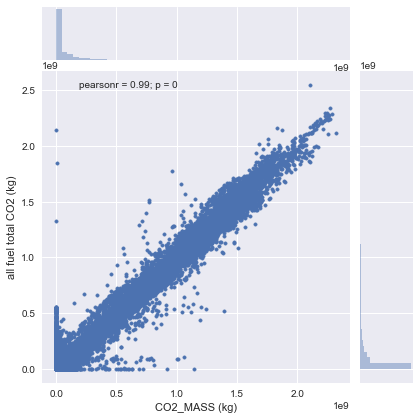

In [14]:
sns.jointplot('CO2_MASS (kg)', 'all fuel total CO2 (kg)', epa_adj, marker='.')

### Adjust CO2 emissions where we have a `CO2 ratio` value
Because of the inner merge above, all rows should have a valid CO2 ratio

In [28]:
# Calaculated with an "inner" merge of the dataframes
for year in range(2001, 2017):
    total_co2 = epa_adj.loc[epa_adj['YEAR']==year, 'CO2_MASS (kg)'].sum()
    union_co2 = epa_adj.loc[(epa_adj['YEAR']==year) & 
                            ~(epa_adj['CO2 ratio'].isnull()), 'CO2_MASS (kg)'].sum()
    missing = total_co2 - union_co2
    
    print year, '{:.3%}'.format(union_co2/total_co2), 'accounted for', \
           missing/1000, 'metric tons missing'

2001 100.000% accounted for 0.0 metric tons missing
2002 100.000% accounted for 0.0 metric tons missing
2003 100.000% accounted for 0.0 metric tons missing
2004 100.000% accounted for 0.0 metric tons missing
2005 100.000% accounted for 0.0 metric tons missing
2006 100.000% accounted for 0.0 metric tons missing
2007 100.000% accounted for 0.0 metric tons missing
2008 100.000% accounted for 0.0 metric tons missing
2009 100.000% accounted for 0.0 metric tons missing
2010 100.000% accounted for 0.0 metric tons missing
2011 100.000% accounted for 0.0 metric tons missing
2012 100.000% accounted for 0.0 metric tons missing
2013 100.000% accounted for 0.0 metric tons missing
2014 100.000% accounted for 0.0 metric tons missing
2015 100.000% accounted for 0.0 metric tons missing
2016 100.000% accounted for 0.0 metric tons missing


**Look back at this to ensure that I'm correctly accounting for edge cases**
- Emissions reported to CEMS under a different code than EIA
- Emissions reported to CEMS but not EIA monthly
- Incorrect 0 value reported to CEMS

Start by setting all adjusted CO2 (`adj CO2 (kg)`) values to the reported CO2 value

In [15]:
epa_adj['adj CO2 (kg)'] = epa_adj.loc[:,'CO2_MASS (kg)']

If CEMS reported CO2 emissions are 0 but heat inputs are >0 and calculated CO2 emissions are >0, change the adjusted CO2 to NaN. These NaN values will be replaced by the calculated value later. Do the same for low index records (<300 g/kWh). If there is a valid CO2 ratio, multiply the adjusted CO2 column by the CO2 ratio.

In [16]:
epa_adj.loc[~(epa_adj['CO2_MASS (kg)']>0) &
            (epa_adj['HEAT_INPUT (mmBtu)']>0) &
            (epa_adj['all fuel total CO2 (kg)']>0), 'adj CO2 (kg)'] = np.nan
epa_adj.loc[(epa_adj['epa index']<300) &
            (epa_adj['HEAT_INPUT (mmBtu)']>0) &
            (epa_adj['all fuel total CO2 (kg)']>0), 'adj CO2 (kg)'] = np.nan

epa_adj.loc[epa_adj['CO2 ratio'].notnull(), 'adj CO2 (kg)'] *= epa_adj.loc[epa_adj['CO2 ratio'].notnull(), 'CO2 ratio']

In [17]:
for year in range(2001,2017):
    num_missing = len(epa_adj.loc[(epa_adj['adj CO2 (kg)'].isnull()) & 
                                  (epa_adj['YEAR']==year), 'ORISPL_CODE'].unique())
    total = len(epa_adj.loc[epa_adj['YEAR']==year, 'ORISPL_CODE'].unique())
    
    print 'In', str(year) + ',', num_missing, 'plants missing some data out of', total

In 2001, 141 plants missing some data out of 1013
In 2002, 169 plants missing some data out of 1159
In 2003, 219 plants missing some data out of 1302
In 2004, 231 plants missing some data out of 1356
In 2005, 239 plants missing some data out of 1357
In 2006, 231 plants missing some data out of 1370
In 2007, 223 plants missing some data out of 1379
In 2008, 280 plants missing some data out of 1437
In 2009, 229 plants missing some data out of 1439
In 2010, 196 plants missing some data out of 1440
In 2011, 191 plants missing some data out of 1436
In 2012, 195 plants missing some data out of 1442
In 2013, 178 plants missing some data out of 1433
In 2014, 171 plants missing some data out of 1420
In 2015, 205 plants missing some data out of 1427
In 2016, 103 plants missing some data out of 1393


## Emissions and gen not captured by facilities
Subtract these from the top-line EIA values to get the amount not captured at facilities in each month. EIA natural gas fuel consumption does not include BFG or OG.

### Consolidate facility generation, fuel use, and CO2 emissions 

In [18]:
eia_facility['fuel'].unique()

array(['WAT', 'SLW', 'NG', 'BIT', 'MSB', 'SUB', 'DFO', 'KER', 'MSN', 'JF',
       'RFO', 'WO', 'OBG', 'WC', 'OBL', 'WDS', 'PG', 'OG', 'PC', 'SGC',
       'LFG', 'GEO', 'BLQ', 'WH', 'WND', 'OBS', 'TDF', 'OTH', 'BFG', 'PUR',
       'AB', 'NUC', 'SUN', 'LIG', 'WDL', 'SC', 'RC', 'SGP', 'MSW'], dtype=object)

In [19]:
# OG and BFG are included in Other because I've included OOG in Other below
# Pet liquids and pet coke are included here because they line up with how the state-level
# EIA data are reported
facility_fuel_cats = {'COW' : ['SUB','BIT','LIG', 'WC','SC','RC','SGC'], 
                      'NG' : ['NG'],
                      'PEL' : ['DFO', 'RFO', 'KER', 'JF', 'PG', 'WO', 'SGP'],
                      'PC' : ['PC'],
                      'HYC' : ['WAT'],
                      'HPS' : [],
                      'GEO' : ['GEO'],
                      'NUC' : ['NUC'],
                      'OOG' : ['BFG', 'OG', 'LFG'],
                      'OTH' : ['OTH', 'MSN', 'MSW', 'PUR', 'TDF', 'WH'],
                      'SUN' : ['SUN'],
                      'DPV' : [],
                      'WAS' : ['OBL', 'OBS', 'OBG', 'MSB', 'SLW'],
                      'WND' : ['WND'],
                      'WWW' : ['WDL', 'WDS', 'AB', 'BLQ']
                     }

Create a new df that groups the facility data into more general fuel types that match up with the EIA generation and fuel use totals.

In [20]:
eia_facility_fuel = eia_facility.copy()
for key in facility_fuel_cats.keys():
    eia_facility_fuel.loc[eia_facility_fuel['fuel'].isin(facility_fuel_cats[key]),'type'] = key
eia_facility_fuel = eia_facility_fuel.groupby(['type', 'year', 'month']).sum()
# eia_facility_fuel.reset_index(inplace=True)

eia_facility_fuel.head()

plant id  total fuel (mmbtu)  generation (MWh)  \
type year month                                                   
COW  2001 1       9260856        1.848875e+09      1.762754e+08   
          2       9260856        1.568672e+09      1.488241e+08   
          3       9260856        1.626246e+09      1.541157e+08   
          4       9260856        1.471568e+09      1.398943e+08   
          5       9208831        1.595267e+09      1.507916e+08   

                 elec fuel (mmbtu)           lat           lon  quarter  \
type year month                                                           
COW  2001 1           1.810304e+09  25877.386892 -58610.907488      662   
          2           1.536017e+09  25877.386892 -58610.907488      662   
          3           1.591151e+09  25877.386892 -58610.907488      662   
          4           1.439361e+09  25877.386892 -58610.907488     1324   
          5           1.563698e+09  25882.875792 -58611.276988     1324   

                 all fuel fossil CO2 (kg)  elec fuel fossil CO2 (kg)  \
type year month                                                        
COW  2001 1                  1.755757e+11               1.719629e+11   
          2                  1.490065e+11               1.459476e+11   
          3                  1.544286e+11               1.511424e+11   
          4                  1.397181e+11               1.367018e+11   
          5                  1.515424e+11               1.485856e+11   

                 all fuel total CO2 (kg)  elec fuel total CO2 (kg)  
type year month                                                     
COW  2001 1                 1.755757e+11              1.719629e+11  
          2                 1.490065e+11              1.459476e+11  
          3                 1.544286e+11              1.511424e+11  
          4                 1.397181e+11              1.367018e+11  
          5                 1.515424e+11              1.485856e+11

### Extra generation and fuel use

In [21]:
eia_total_monthly.head()

generation (MWh)  total fuel (mmbtu)  elec fuel (mmbtu)  \
type year month                                                            
COW  2001 1           177287111.0        1.865793e+09       1.823462e+09   
          2           149735484.0        1.583640e+09       1.547591e+09   
          3           155269011.0        1.644568e+09       1.605916e+09   
          4           140670654.0        1.485098e+09       1.449735e+09   
          5           151592914.0        1.609281e+09       1.574618e+09   

                 all fuel CO2 (kg)  elec fuel CO2 (kg)  
type year month                                         
COW  2001 1           1.777168e+11        1.736848e+11  
          2           1.508417e+11        1.474080e+11  
          3           1.566451e+11        1.529635e+11  
          4           1.414556e+11        1.380873e+11  
          5           1.532840e+11        1.499824e+11

In [22]:
iterables = [eia_total_monthly.index.levels[0], range(2001, 2017), range(1, 13)]
index = pd.MultiIndex.from_product(iterables=iterables, names=['type', 'year', 'month'])
eia_extra = pd.DataFrame(index=index, columns=['total fuel (mmbtu)', 'generation (MWh)',
                                               'elec fuel (mmbtu)'])

In [23]:
idx = pd.IndexSlice

In [24]:
use_columns=['total fuel (mmbtu)', 'generation (MWh)',
                                               'elec fuel (mmbtu)']
eia_extra = (eia_total_monthly.loc[idx[:,:,:], use_columns] - 
             eia_facility_fuel.loc[idx[:,:,:], use_columns])

# I have lumped hydro pumped storage in with conventional hydro in the facility data.
# Because of this, I need to add HPS rows so that the totals will add up correctly.
# Also need to add DPV because it won't show up otherwise
eia_extra.loc[idx[['HPS', 'DPV'],:,:], use_columns] = eia_total_monthly.loc[idx[['HPS', 'DPV'],:,:], use_columns]
# eia_extra = eia_extra.loc[idx[:, 2003:, :],:]

In [25]:
eia_extra.head()

total fuel (mmbtu)  generation (MWh)  elec fuel (mmbtu)
type year month                                                         
COW  2001 1              16918390.0       1011665.061         13157576.0
          2              14968346.0        911346.865         11574491.0
          3              18321543.0       1153328.913         14765162.0
          4              13530117.0        776341.623         10374008.0
          5              14014024.0        801266.923         10920463.0

In [26]:
eia_extra.loc[idx['DPV',:,:]]

total fuel (mmbtu)  generation (MWh)  elec fuel (mmbtu)
type year month                                                         
DPV  2014 1                     NaN         624032.82                NaN
          2                     NaN         663828.73                NaN
          3                     NaN         907029.95                NaN
          4                     NaN         988423.77                NaN
          5                     NaN        1092011.80                NaN
          6                     NaN        1100560.82                NaN
          7                     NaN        1148527.79                NaN
          8                     NaN        1139134.66                NaN
          9                     NaN        1046360.70                NaN
          10                    NaN         964877.96                NaN
          11                    NaN         791801.55                NaN
          12                    NaN         766068.15                NaN
     2015 1                     NaN         746445.84                NaN
          2                     NaN         815764.50                NaN
          3                     NaN        1133577.23                NaN
          4                     NaN        1263528.30                NaN
          5                     NaN        1393836.75                NaN
          6                     NaN        1408013.52                NaN
          7                     NaN        1486681.59                NaN
          8                     NaN        1468048.33                NaN
          9                     NaN        1329651.46                NaN
          10                    NaN        1197707.54                NaN
          11                    NaN         982048.27                NaN
          12                    NaN         913963.95                NaN
     2016 1                     NaN        1020588.78                NaN
          2                     NaN        1189469.53                NaN
          3                     NaN        1582361.09                NaN
          4                     NaN        1763404.74                NaN
          5                     NaN        1944571.47                NaN
          6                     NaN        1991456.73                NaN
          7                     NaN        2065890.59                NaN
          8                     NaN        2003636.20                NaN
          9                     NaN        1789836.27                NaN
          10                    NaN        1607185.85                NaN
          11                    NaN        1306748.99                NaN
          12                    NaN        1201677.95                NaN

### Calculate extra electric fuel CO2 emissions

In [27]:
path = os.path.join('Final emission factors.csv')
ef = pd.read_csv(path, index_col=0)

We need to approximate some of the emission factors because the state-level EIA data is only available in the bulk download at an aggregated level. Natural gas usually makes up the bulk of this extra electric generation/fuel use (consumption not reported by facilities, estimated by EIA), and it is still a single fuel here.

In [28]:
fuel_factors = {'NG' : ef.loc['NG', 'Fossil Factor'],
                   'PEL': ef.loc[['DFO', 'RFO'], 'Fossil Factor'].mean(),
                   'PC' : ef.loc['PC', 'Fossil Factor'], 
                   'COW' : ef.loc[['BIT', 'SUB'], 'Fossil Factor'].mean(),
                   'OOG' : ef.loc['OG', 'Fossil Factor']}

In [29]:
# Start with 0 emissions in all rows
# For fuels where we have an emission factor, replace the 0 with the calculated value
eia_extra['all fuel CO2 (kg)'] = 0
eia_extra['elec fuel CO2 (kg)'] = 0
for fuel in fuel_factors.keys():
    eia_extra.loc[idx[fuel,:,:],'all fuel CO2 (kg)'] = \
        eia_extra.loc[idx[fuel,:,:],'total fuel (mmbtu)'] * fuel_factors[fuel]
        
    eia_extra.loc[idx[fuel,:,:],'elec fuel CO2 (kg)'] = \
        eia_extra.loc[idx[fuel,:,:],'elec fuel (mmbtu)'] * fuel_factors[fuel]
        
# eia_extra.reset_index(inplace=True)
# add_quarter(eia_extra)

In [30]:
eia_extra.loc[idx['NG',:,:],].tail()

total fuel (mmbtu)  generation (MWh)  elec fuel (mmbtu)  \
type year month                                                            
NG   2016 8             113483580.0       8771123.171         76113078.0   
          9              92669757.0       6807972.734         58768974.0   
          10             81146370.0       5686910.460         49408994.0   
          11             79733264.0       5334036.489         46334703.0   
          12             83261980.0       5452905.893         47673785.0   

                 all fuel CO2 (kg)  elec fuel CO2 (kg)  
type year month                                         
NG   2016 8           6.022574e+09        4.039321e+09  
          9           4.917984e+09        3.118869e+09  
          10          4.306438e+09        2.622135e+09  
          11          4.231444e+09        2.458983e+09  
          12          4.418713e+09        2.530048e+09

## Add EPA facility-level emissions back to the EIA facility df, use EIA emissions where EPA don't exist, add extra EIA emissions for state-level data
The dataframes start at a facility level. Extra EIA emissions for estimated state-level data are added after they are aggregated by year/month in the "Monthly Index" section below.

In [31]:
epa_cols = ['ORISPL_CODE', 'YEAR', 'MONTH', 'adj CO2 (kg)']
final_co2_gen = eia_facility_grouped.merge(epa_adj.loc[:,epa_cols], left_on=['plant id', 'year', 'month'], 
                                         right_on=['ORISPL_CODE', 'YEAR', 'MONTH'], how='left')
final_co2_gen.drop(['ORISPL_CODE', 'YEAR', 'MONTH'], axis=1, inplace=True)
final_co2_gen['final CO2 (kg)'] = final_co2_gen['adj CO2 (kg)']
final_co2_gen.loc[final_co2_gen['final CO2 (kg)'].isnull(), 'final CO2 (kg)'] = final_co2_gen.loc[final_co2_gen['final CO2 (kg)'].isnull(), 'elec fuel fossil CO2 (kg)']
add_quarter(final_co2_gen)

In [32]:
final_co2_gen.head()

,year,month,plant id,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg),generation (MWh),CO2 ratio,adj CO2 (kg),final CO2 (kg),datetime,quarter
0,2001,1,2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,18918.0,0.0,NaN,0.000000e+00,2001-01-01,1
1,2001,1,3,8.905017e+08,8.905017e+08,8.905017e+08,8.905017e+08,1158644.0,1.0,9.625411e+08,9.625411e+08,2001-01-01,1
2,2001,1,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,51843.0,0.0,NaN,0.000000e+00,2001-01-01,1
3,2001,1,7,5.501578e+07,5.501578e+07,5.501578e+07,5.501578e+07,46411.0,1.0,6.700092e+07,6.700092e+07,2001-01-01,1
4,2001,1,8,6.457039e+08,6.457039e+08,6.457039e+08,6.457039e+08,707902.0,1.0,7.530204e+08,7.530204e+08,2001-01-01,1


## Final index values

Start with some helper functions to convert units and calculate % change from 2005 annual value

In [33]:
def g2lb(df):
    """
    Convert g/kWh to lb/MWh and add a column to the df
    """
    kg2lb = 2.2046
    df['index (lb/MWh)'] = df['index (g/kWh)'] * kg2lb
    
def change_since_2005(df):
    """
    Calculate the % difference from 2005 and add as a column in the df
    """
    # first calculate the index in 2005 
    index_2005 = ((df.loc[df['year']==2005,'index (g/kWh)'] * 
                df.loc[df['year']==2005,'generation (MWh)']) / 
             df.loc[df['year']==2005,'generation (MWh)'].sum()).sum()
    
    # Calculated index value in 2005 is 599.8484560355034
    # If the value above is different throw an error
    if (index_2005 > 601) or (index_2005 < 599.5):
        raise ValueError('Calculated 2005 index value', index_2005, 
                         'is outside expected range. Expected value is 599.848')
    if type(index_2005) != float:
        raise TypeError('index_2005 is', type(index_2005), 'rather than a float.')
    
    df['change since 2005'] = (df['index (g/kWh)'] - index_2005) / index_2005

### Monthly Index
Adding generation and emissions not captured in the facility-level data

In [34]:
monthly_index = final_co2_gen.groupby(['year', 'month'])['generation (MWh)', 'final CO2 (kg)'].sum()
monthly_index.reset_index(inplace=True)

# Add extra generation and emissions not captured by facility-level data
monthly_index.loc[:,'final CO2 (kg)'] += eia_extra.reset_index().groupby(['year', 'month'])['elec fuel CO2 (kg)'].sum().values
monthly_index.loc[:,'generation (MWh)'] += eia_extra.reset_index().groupby(['year', 'month'])['generation (MWh)'].sum().values
add_quarter(monthly_index)
monthly_index['index (g/kWh)'] = monthly_index.loc[:, 'final CO2 (kg)'] / monthly_index.loc[:, 'generation (MWh)']

change_since_2005(monthly_index)
g2lb(monthly_index)
monthly_index.dropna(inplace=True)

In [36]:
monthly_index.tail()

,year,month,generation (MWh),final CO2 (kg),datetime,quarter,index (g/kWh),change since 2005,index (lb/MWh)
187,2016,8,4.121169e+08,2.075103e+11,2016-08-01,3,503.522947,-0.161845,1110.066690
188,2016,9,3.535587e+08,1.719623e+11,2016-09-01,3,486.375499,-0.190389,1072.263425
189,2016,10,3.144356e+08,1.454571e+11,2016-10-01,4,462.597438,-0.229969,1019.842313
190,2016,11,2.987341e+08,1.293222e+11,2016-11-01,4,432.900588,-0.279402,954.372636
191,2016,12,3.464400e+08,1.608125e+11,2016-12-01,4,464.185868,-0.227325,1023.344164


In [205]:
path = os.path.join('Data for plots', 'Monthly index.csv')
monthly_index.to_csv(path, index=False)

### Quarterly Index
Built up from the monthly index

In [35]:
quarterly_index = monthly_index.groupby(['year', 'quarter'])['generation (MWh)', 'final CO2 (kg)'].sum()
quarterly_index.reset_index(inplace=True)
quarterly_index['index (g/kWh)'] = quarterly_index.loc[:, 'final CO2 (kg)'] / quarterly_index.loc[:, 'generation (MWh)']
quarterly_index['year_quarter'] = quarterly_index['year'].astype(str) + ' Q' + quarterly_index['quarter'].astype(str)
change_since_2005(quarterly_index)
g2lb(quarterly_index)

In [37]:
quarterly_index.tail()

,year,quarter,generation (MWh),final CO2 (kg),index (g/kWh),year_quarter,change since 2005,index (lb/MWh)
59,2015,4,9.402859e+08,4.234998e+11,450.394729,2015 Q4,-0.250281,992.940220
60,2016,1,9.742390e+08,4.186768e+11,429.747480,2016 Q1,-0.284650,947.421294
61,2016,2,9.840972e+08,4.274216e+11,434.328645,2016 Q2,-0.277025,957.520930
62,2016,3,1.180191e+09,5.866387e+11,497.070992,2016 Q3,-0.172585,1095.842710
63,2016,4,9.596097e+08,4.355918e+11,453.926031,2016 Q4,-0.244403,1000.725328


In [209]:
path = os.path.join('Data for plots', 'Quarterly index.csv')
quarterly_index.to_csv(path, index=False)

### Annual Index

In [38]:
annual_index = quarterly_index.groupby('year')['generation (MWh)', 'final CO2 (kg)'].sum()
annual_index.reset_index(inplace=True)

annual_index['index (g/kWh)'] = annual_index.loc[:, 'final CO2 (kg)'] / annual_index.loc[:, 'generation (MWh)']

change_since_2005(annual_index)
g2lb(annual_index)

annual_index.tail()

,year,generation (MWh),final CO2 (kg),index (g/kWh),change since 2005,index (lb/MWh)
11,2012,4.047765e+09,2.084286e+12,514.922581,-0.142870,1135.198322
12,2013,4.065964e+09,2.102529e+12,517.104642,-0.139237,1140.008893
13,2014,4.104839e+09,2.098239e+12,511.162336,-0.149129,1126.908485
14,2015,4.091740e+09,1.973193e+12,482.238163,-0.197275,1063.142253
15,2016,4.098137e+09,1.868329e+12,455.897140,-0.241122,1005.070835


In [211]:
path = os.path.join('Data for plots', 'Annual index.csv')
annual_index.to_csv(path, index=False)

#### Export to Excel file

In [41]:
'US POWER SECTOR CO2 EMISSIONS INTENSITY'.title()

'Us Power Sector Co2 Emissions Intensity'

In [44]:
path = os.path.join('..', 'Calculated values', 'US Power Sector CO2 Emissions Intensity.xlsx')
writer = pd.ExcelWriter(path)

monthly_index.to_excel(writer, sheet_name='Monthly', index=False)
quarterly_index.to_excel(writer, sheet_name='Quarterly', index=False)
annual_index.to_excel(writer, sheet_name='Annual', index=False)
writer.save()

## Generation by fuel

In [46]:
fuel_cats = {'Coal' : [u'COW'], 
             'Natural Gas' : [u'NG'],
             'Nuclear' : ['NUC'],
             'Renewables' : [u'GEO', u'HYC', u'SUN', 'DPV', 
                             u'WAS', u'WND', u'WWW'],
             'Other' : [u'OOG', u'PC', u'PEL', u'OTH', u'HPS']
             }
keep_types = [u'WWW', u'WND', u'WAS', u'SUN', 'DPV', u'NUC', u'NG',
       u'PEL', u'PC', u'OTH', u'COW', u'OOG', u'HPS', u'HYC', u'GEO']

In [94]:
eia_gen_monthly = eia_total.loc[eia_total['type'].isin(keep_types)].groupby(['type', 'year', 'month']).sum()
eia_gen_monthly.reset_index(inplace=True)
eia_gen_monthly.drop(['end', 'sector', 'start'], inplace=True, axis=1)

for key, values in fuel_cats.iteritems():
    eia_gen_monthly.loc[eia_gen_monthly['type'].isin(values),'fuel category'] = key

eia_gen_monthly = eia_gen_monthly.groupby(['fuel category', 'year', 'month']).sum()
eia_gen_monthly.reset_index(inplace=True)  

add_quarter(eia_gen_monthly)

eia_gen_quarterly = eia_gen_monthly.groupby(['fuel category', 'year', 'quarter']).sum()
eia_gen_quarterly.reset_index(inplace=True)
eia_gen_quarterly['year_quarter'] = (eia_gen_quarterly['year'].astype(str) + 
                                     ' Q' + eia_gen_quarterly['quarter'].astype(str))
eia_gen_quarterly.drop('month', axis=1, inplace=True)

eia_gen_annual = eia_gen_monthly.groupby(['fuel category', 'year']).sum()
eia_gen_annual.reset_index(inplace=True)
eia_gen_annual.drop(['month', 'quarter'], axis=1, inplace=True)

### A function to estimate the emissions intensity of each fuel over time, making sure that they add up to the total emissions intensity.

In [95]:
def generation_index(gen_df, index_df, group_by='year'):
    """
    Calculate the emissions intensity of each fuel in each time period. Use the
    adjusted total emissions from the index dataframe to ensure that the weighted
    sum of fuel emission intensities will equal the total index value.
    """
    final_adj_co2 = index_df.loc[:,'final CO2 (kg)'].copy()
    
    calc_total_co2 = gen_df.groupby(group_by)['elec fuel CO2 (kg)'].sum().values
#     calc_total_co2 = calc_total_co2.reset_index()
    
    
    for fuel in gen_df['fuel category'].unique():
        gen_df.loc[gen_df['fuel category']==fuel, 'adjusted CO2 (kg)'] = (gen_df.loc[gen_df['fuel category']==fuel, 
                                                                                     'elec fuel CO2 (kg)'] / 
                                                                           calc_total_co2 * 
                                                                           final_adj_co2.values)
    
    gen_df['adjusted index (g/kWh)'] = gen_df['adjusted CO2 (kg)']  /  gen_df['generation (MWh)']
    gen_df['adjusted index (lb/MWh)'] = gen_df['adjusted index (g/kWh)'] * 2.2046
        
    
    

Apply the function above to each generation dataframe

In [96]:
generation_index(eia_gen_annual, annual_index, 'year')

In [97]:
generation_index(eia_gen_monthly, monthly_index, ['year', 'month'])

In [98]:
generation_index(eia_gen_quarterly, quarterly_index, 'year_quarter')

In [100]:
eia_gen_annual.head()

,fuel category,year,generation (MWh),total fuel (mmbtu),elec fuel (mmbtu),all fuel CO2 (kg),elec fuel CO2 (kg),adjusted CO2 (kg),adjusted index (g/kWh),adjusted index (lb/MWh)
0,Coal,2001,1.903956e+09,2.023230e+10,1.978945e+10,1.927126e+12,1.884945e+12,1.926002e+12,1011.578855,2230.126744
1,Coal,2002,1.933130e+09,2.041797e+10,1.999689e+10,1.944812e+12,1.904704e+12,1.957361e+12,1012.534282,2232.233077
2,Coal,2003,1.973737e+09,2.078358e+10,2.036688e+10,1.979636e+12,1.939945e+12,1.991106e+12,1008.800426,2224.001420
3,Coal,2004,1.978301e+09,2.094025e+10,2.037575e+10,1.994559e+12,1.940790e+12,1.974951e+12,998.306910,2200.867414
4,Coal,2005,2.012873e+09,2.135038e+10,2.080172e+10,2.033624e+12,1.981363e+12,2.000007e+12,993.608155,2190.508538


#### Export files

In [ ]:
path = os.path.join('Data for plots', 'Monthly generation.csv')
eia_gen_monthly.to_csv(path, index=False)

In [219]:
path = os.path.join('Data for plots', 'Quarterly generation.csv')
eia_gen_quarterly.to_csv(path, index=False)

In [220]:
path = os.path.join('Data for plots', 'Annual generation.csv')
eia_gen_annual.to_csv(path, index=False)

#### Export to Excel file

In [75]:
path = os.path.join('..', 'Calculated values', 'US Generation By Fuel Type.xlsx')
writer = pd.ExcelWriter(path, engine='xlsxwriter')

eia_gen_monthly.to_excel(writer, sheet_name='Monthly', index=False)

eia_gen_quarterly.to_excel(writer, sheet_name='Quarterly', index=False)

eia_gen_annual.to_excel(writer, sheet_name='Annual', index=False)
writer.save()